# Final Project CSE 402
## By: Pihu Sharma, Shayna McConville, Livia Perelli, Meghana Reddy, Emma Choueiry

## Part 1 Data Preperation

### Imports

In [18]:
import os
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


### Gathering Data

In [2]:
data_dir = "Celebrity Faces Dataset"  # clean folder
classes = sorted([f for f in os.listdir(data_dir) if not f.startswith('.')])

print("Classes:", classes)
print("Number of classes:", len(classes))

Classes: ['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']
Number of classes: 17


### Rebuilding Image Paths and Labels

In [3]:
image_paths = []
labels = []

for idx, cls in enumerate(classes):
    cls_folder = os.path.join(data_dir, cls)
    for file in os.listdir(cls_folder):
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(cls_folder, file))
            labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"Detected {len(classes)} classes and {len(image_paths)} images.")


Detected 17 classes and 1700 images.


### Split Per Identity

In [4]:
num_classes = len(classes)
folds = 10

# group images by class
images_by_class = [[] for _ in range(num_classes)]
for path, label in zip(image_paths, labels):
    images_by_class[label].append(path)

# sort images
for c in range(num_classes):
    images_by_class[c].sort()

# split into 10 folds
folds_by_class = [[] for _ in range(num_classes)]
for c in range(num_classes):
    imgs = images_by_class[c]
    n = len(imgs)
    per_fold = n // folds
    if n % folds != 0:
        print(f"Warning: class {c} has {n} images.")
    class_folds = [imgs[k*per_fold:(k+1)*per_fold] for k in range(folds)]
    folds_by_class[c] = class_folds

print("10-fold split complete.")


10-fold split complete.


---

## Part 2 Face Recognition Models

---

### Model Set Up

In [19]:
device = torch.device("cpu")
alexnet = models.alexnet(pretrained=True).to(device)
alexnet.eval()  

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Feature Extraction

In [13]:
feature_extractor = torch.nn.Sequential(*list(alexnet.children())[:-1]).to(device)
feature_extractor.eval()
#feature_extractor

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
)

In [10]:
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
#transform_image


### Train and Test Paths

In [14]:
def get_fold_split(fold_idx):
    train_paths, train_labels = [], []
    test_paths, test_labels = [], []
    
    for c in range(num_classes):
        for k in range(folds):
            imgs = folds_by_class[c][k]
            if k == fold_idx:
                test_paths.extend(imgs)
                test_labels.extend([c] * len(imgs))
            else:
                train_paths.extend(imgs)
                train_labels.extend([c] * len(imgs))
    
    return train_paths, train_labels, test_paths, test_labels

# quick check
train_paths, train_labels, test_paths, test_labels = get_fold_split(0)
print(len(train_paths), "train images,", len(test_paths), "test images")


1530 train images, 170 test images


### Extract AlexNet features for image paths

In [15]:
from PIL import Image
import torch

def extract_features(image_paths):
    feats = []
    with torch.no_grad():
        for p in image_paths:
            img = Image.open(p).convert("RGB")
            x = transform_image(img).unsqueeze(0).to(device)
            f = feature_extractor(x)
            f = f.view(f.size(0), -1)  # flatten
            feats.append(f.cpu())
    return torch.cat(feats, dim=0)


In [21]:
#Test on tiny subset
train_feats = extract_features(train_paths[:10])
print(train_feats.shape)


torch.Size([10, 9216])


---

## Part 3 Evaluation

---

### Classifier and LOOCV loop

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def run_loocv():
    all_true = []
    all_pred = []
    
    for fold_idx in range(folds):
        train_paths, train_labels, test_paths, test_labels = get_fold_split(fold_idx)
        
        X_train = extract_features(train_paths).numpy()
        y_train = np.array(train_labels)
        X_test = extract_features(test_paths).numpy()
        y_test = np.array(test_labels)
        
        clf = LogisticRegression(max_iter=1000, multi_class="multinomial")
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        fold_acc = accuracy_score(y_test, y_pred)
        print(f"Fold {fold_idx}: accuracy = {fold_acc:.4f}")
        
        all_true.extend(y_test.tolist())
        all_pred.extend(y_pred.tolist())
    
    all_true = np.array(all_true)
    all_pred = np.array(all_pred)
    overall_acc = accuracy_score(all_true, all_pred)
    print(f"\nOverall LOOCV accuracy = {overall_acc:.4f}")
    
    return all_true, all_pred

all_true, all_pred = run_loocv()


Fold 0: accuracy = 0.7412
Fold 1: accuracy = 0.6882
Fold 2: accuracy = 0.6529
Fold 3: accuracy = 0.6000
Fold 4: accuracy = 0.5647
Fold 5: accuracy = 0.5647
Fold 6: accuracy = 0.6118
Fold 7: accuracy = 0.5176
Fold 8: accuracy = 0.5294
Fold 9: accuracy = 0.5176

Overall LOOCV accuracy = 0.5988


### Confusion Maxtrix

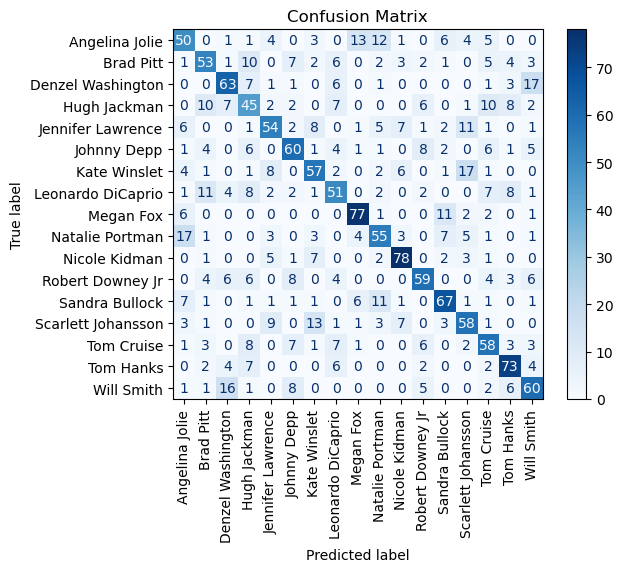

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
    all_true, all_pred, 
    display_labels=classes, 
    xticks_rotation='vertical',
    cmap='Blues'
)
plt.title("Confusion Matrix")
plt.show()


# To save image
#plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
